Progetto realizzato da: Siri Filippo (4819642)<br>Analisi del dataset TED Talks

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
ted = pd.read_csv('data.csv')

Dopo aver importato le varie librerie necessarie ed il file CSV, iniziamo l'analisi del dataset andando a vedere le colonne presenti e la dimensione del dataset.

In [ ]:
ted.head()

In [ ]:
ted.shape

Per prima cosa analizziamo le feature del dataset dividendole in qualitative e quantitative. In questo modo andiamo possiamo farci una prima idea dei valori presenti ed andiamo a trovare eventuali valori nulli.

In [ ]:
ted_quantitative = ted[['views','likes']]
ted_qualitative = ted[['title', 'author', 'date', 'link']]

In [ ]:
ted_quantitative.describe().apply(lambda s: s.apply('{0:.5f}'.format))

Le feature quantitative presenti nel dataset `views` e `likes`. È possibile notare che non sono presenti valori nulli e che non esistono talks che non sono mai stati guardati (valore minimo di views 532) o che non hanno ricevuto nemmeno un like. 

In [ ]:
ted_qualitative.describe()

Le feature qualitative presenti nel dataset sono `title`, `author`, `date` e `link`. Si può notare che non esistono talks con lo stesso titolo e che un autore può pubblicare diversi talks. Abbiamo anche trovato che l'autore che ha pubblicato il maggior numero di talks è `Alex Gendler`. Siccome sono presenti 5439 valori per la feature `author`, vuol dire che è presente un talk con il campo `author` nullo.

In [ ]:
ted[ted.isnull().any(axis=1)]

Abbiamo trovato che il talk con `author` nullo è un video che racchiude parti dei vari talk presentati durante l'anno. Decidiamo di rimpiazzare il valore nullo con `Unknown author`.

In [ ]:
ted['author'].fillna('Unknown author', inplace=True)
ted.isnull().sum()

Adesso vogliamo vedere se è presente una correlazione tra il numero di views ed il numero di likes (le due feature quantitative).

In [ ]:
ted.corr()

In [ ]:
plt.scatter(ted['views'], ted['likes'])

È possibile notare che è presente una forte correlazione ed è possibile notarlo anche dal grafico.


Siccome è presente questa forte correlazione, vogliamo implementare ed allenare un modello di regressione lineare che consenta di prevedere il numero di likes dato il numero di views. Dividiamo il dataset nel training set (utilizzato per allenare il modello) e nel validation set (utilizzato per verificare il modello). Per dividere il dataset usiamo come rapporto 70/30 (training/validation).


In [ ]:
features = ['views']
x = ted[features]
y = ted['likes']
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3)
regressor = LinearRegression()
lin_reg = regressor.fit(X_train, y_train)

print("Score:",regressor.score(X_valid, y_valid))

Grazie all'alta correlazione presente tra numero di views e numero di likes abbiamo ottenuto uno score molto alto e quindi la funzione generata sarà in grado di approssimare correttamente l'andamento dei dati.

La funzione ottenuta è caratterizzata dalle seguenti componenti:

In [ ]:
print('Coefficiente:', lin_reg.coef_)
print('Intercetta:', lin_reg.intercept_)

Per vedere meglio la funzione ottenuta andiamo ad osservare il grafico

In [ ]:
plt.scatter(X_train, y_train)

y_hat = X_train * lin_reg.coef_ + lin_reg.intercept_

plt.plot(X_train, y_hat, color='r') 

Adesso andiamo a vedere quali sono i talks con il maggior numero di views e con il maggior numero di likes. Siccome è presente questa forte correlazione ci aspettiamo di trovare più o meno gli stessi talks.

In [ ]:
bestTalksByViews = ted.sort_values(by='views', ascending=False, ignore_index=True).nlargest(20, 'views')[['author', 'title', 'date', 'views']]
bestTalksByViews

In [ ]:
bestTalksByLikes = ted.sort_values(by='likes', ascending=False, ignore_index=True).nlargest(20, 'likes')[['author', 'title', 'date', 'likes']]
bestTalksByLikes

Come ci aspettavamo, la maggior parte dei talks con più views sono anche quelli con più likes. Adesso andiamo a vedere quali sono i talks con il miglior rapporto `#likes/#views`.

In [ ]:
ted['ratio']=ted['likes'].div(ted['views'])
ted.sort_values(by='ratio', ascending=False, ignore_index=True).nlargest(20, 'ratio')[['author', 'title', 'ratio']]

Si può osservare che nessuno dei talks più visti o con più likes compare nella classifica dei talks con il rapporto migliore.

Andiamo a vedere quali sono gli autori che hanno prodotto il maggior numero di talks e quali hanno ottenuto il maggior numero di views per vedere se è presente una correlazione tra le due cose.

In [ ]:
authorProduct = ted.sort_values(by='author')['author'].value_counts()
authorProductLimited = authorProduct.nlargest(10)


authorViews = ted.sort_values(by='author').groupby('author')['views'].sum() #normalizzazione
authorViewsLimited = authorViews.nlargest(10)



plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
authorProductLimited.plot(kind='bar', title="Autori che hanno prodotto il maggior numero di talks")
plt.subplot(1,2,2)
authorViewsLimited.plot(kind='bar', title="Autori che hanno ottenuto il maggior numero di views")

Si può notare come, tranne Alex Gendler, la maggior parte degli autori con il maggior numero di views non corrispondano con quelli che hanno pubblicato più talks. Andiamo a vedere se è presente una correlazione tra il numero di talks pubblicati ed il numero di views di un autore utilizzando l'intero dataset.

In [ ]:
plt.scatter(authorViews, authorProduct.sort_index())

In [ ]:
authorViews.sort_index().corr(authorProduct.sort_index())

È presente una moderata correlazione tra numero di talks prodotti e numero di views registrate.

Adesso vogliamo andare a vedere se è presente una preferenza sui mesi dove pubblicare i talks.

In [ ]:
import calendar
ted['month'] = ted['date'].str.split(' ', expand=True)[0]

ted['month']=pd.Categorical(ted['month'], categories=list(calendar.month_name)[1::], ordered=True)
views = ted.sort_values(by='month').groupby('month')['views'].sum()

views.plot(kind='bar')

Si può notare come nei mesi dove sono presenti le festività (gennaio, agosto e dicembre) sono stati pubblicati il minor numero di talks.

Adesso andiamo a vedere l'andamento annuale di visualizzazioni e pubblicazioni di nuovi talks.

In [ ]:
ted['year'] = [int(x) for x in ted['date'].str.split(' ', expand=True)[1]]

In [ ]:
views = ted.groupby('year')['views'].sum()#/ted['views'].sum() #normalizzazione
year = ted['year'].value_counts().sort_index()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
views.plot(kind='bar', color='blue', title="Views per anno")
plt.subplot(1,2,2)
year.plot(kind='bar', color='red', title="Pubblicazioni per anno")




È possibile osservare che l'andamento del numero di pubblicazioni in un anno è simile a quello del numero di views, ma dal 2015 al 2019 i due andamenti sono andati diversamente, infatti mentre dal 2015 si è iniziato a registrare un calo nel numero di views, il numero di pubblicazioni ha continuato a crescere sino al 2019.
Per osservare meglio i due andamenti andiamo a sovrapporre i due grafici.

È possibile notare come in realtà sino al 2019 sono stati prodotti un numero sempre maggiore di talks, quindi questo ci fa pensare che a partire dal 2015 la gente ha iniziato a perdere interesse siccome è presente un aumento di talks prodotti (sino al 2019), ma una diminuzione nelle views.
<br><br>
Per vedere meglio i risultati ottenuti, andiamo a creare un grafico contenente i due risultati ottenuti. In questo caso i dati vengono normalizzati. Vengono rappresentati con la riga rossa il numero di talks prodotti e con la riga blu il numero di views registrate.

In [ ]:
yearN = ted['year'].value_counts(normalize=True).sort_index()
viewsN = views.div(views.sum())

ax = viewsN.plot(kind='line', color='blue')
ax = yearN.plot(ax=ax, kind='line', color='red')

Un altro andamento che vogliamo osservare è quello del numero medio di views per anno. Sicuramente ci aspettiamo che a partire dal 2015 sia calato siccome, come abbiamo visto in precedenza, dal 2015 al 2019 sono aumentati il numero di talks prodotti, ma diminuiva il numero di views.

In [ ]:
meanV = ted.groupby('year')['views'].mean().sort_index()
ax = meanV.plot(kind='bar')

Come ci aspettavamo a partire dal 2015 c'è stata una continua diminuzione del numero medio di views. Gli anni in cui le views medie sono andate meglio sono il 2004 ed il 2006. Andiamo a vedere quali sono i talks con più views pubblicati in quei due anni.


In [ ]:
ted[ted['year'] == 2004].sort_values(by='views', ascending=False, ignore_index=True).nlargest(10, 'views')[['author', 'title', 'views']]

In [ ]:
ted[ted['year'] == 2006].sort_values(by='views', ascending=False, ignore_index=True).nlargest(10, 'views')[['author', 'title', 'views']]

Si può notare come solo nel 2006 è presente uno dei 20 talks più visti in assoluto. Adesso andiamo a confrontare la distribuzione delle views in questi due anni con la distribuzione generale.

In [ ]:
plt.figure(figsize=(15,5))
labels = np.arange(0, 9e7, 1e7)

plt.subplot(1,3,1)
ax = ted[ted['year'] == 2004]['views'].plot(kind='box', title='2004')
_ = ax.set_yticks(labels)

plt.subplot(1,3,2)
ax = ted[ted['year'] == 2006]['views'].plot(kind='box', title='2006')
_ = ax.set_yticks(labels)

plt.subplot(1,3,3)
ax = ted['views'].plot(kind='box', title='Generale')
_ = ax.set_yticks(labels)

Per poter vedere meglio la distribuzione, andiamo a vedere la distribuzione considerando solo i talks con meno di 1e7 views.

In [ ]:
plt.figure(figsize=(15,5))
labels = np.arange(0, 1e7+2e6, 1e6)
less = ted[ted['views'] < 1e7]


plt.subplot(1,3,1)
ax = less[ted['year'] == 2004]['views'].plot(kind='box', title='2004 e meno di 1e7 views')
_ = ax.set_yticks(labels)

plt.subplot(1,3,2)
ax = less[ted['year'] == 2006]['views'].plot(kind='box', title='2006 e meno di 1e7 views')
_ = ax.set_yticks(labels)

plt.subplot(1,3,3)
ax = less['views'].plot(kind='box', title='Meno di 1e7 views')
_ = ax.set_yticks(labels)

Si può osservare che la distribuzione delle views dei talks prodotti nel 2004 e nel 2006 e quella generale sono molto simili tra loro.

Un altro tipo di analisi che vogliamo fare è sui titoli, infatti vogliamo vedere se sono presenti delle parole che compaiono la maggior parte delle volte per provare a trovare le tematiche più comuni.

In [ ]:
import nltk
from nltk.corpus import stopwords
from termcolor import colored
nltk.download('stopwords')

def getWords(ds):
  banned = list(stopwords.words('english'))+['—', 'new', 'us', 'could', 'we\'re']
  wordsList=[]
  for v in ds.values:
    for w in v.split():
      if w.lower() not in banned:
        wordsList.append(w.lower())
  words = pd.DataFrame({'word':wordsList})['word'].value_counts().nlargest(6)
  return words

def getWordsColor(w, c):
  word_color=dict()
  count=0
  for w in words.index: 
    word_color[w]=c[count]
    count+=1
  return word_color

def plotWords(w, c):
  ax = words.plot(kind='bar')
  count=0
  for rect in ax.patches:
    rect.set_color(c[count])
    count+=1

def printTitleColor(t, w_dictionary):
  for title in t:
    for w in title.split():
      if w.lower() in w_dictionary:
        print(colored(w, w_dictionary[w.lower()]), end=' ')
      else:
        print(w, end=' ')
    print()

In [ ]:
color=['red','green','yellow','blue','magenta','cyan']

words=getWords(ted['title'])
word_color=getWordsColor(words,color)
plotWords(words,color)

Tra le paroli più comuni, si può notare come siano presenti, quasi nella stessa quantità, le parole `climate` e `change`, a suggerire come uno dei temi più importanti degli ultimi anni, ossia il cambiamento climatico, venga trattato molto frequentemente anche nei talks presenti su Ted Talks. Andiamo a verificare quante volte compaiono nello stesso titolo.

In [ ]:
countBoth=0
countClimate=0
countChange=0
for v in ted['title'].values:
  v = v.lower()
  if 'climate' in v and 'change' in v:
    countBoth+=1
  if 'climate' in v:
    countClimate+=1
  if 'change' in v:
    countChange+=1
print(f"'Climate' compare {countClimate} volte, 'Change' compare {countChange} volte e compaiono entrambe nello stesso titolo {countBoth} volte")

`Change` ovviamente compare più volte essendo anche una parola che può essere usata in diversi abiti, ma è interessante notare come più del 50% delle volte la parola `Climate` compaia insieme a `Change`.



Adesso andiamo a vedere se è presente un legame tra le parole più usate ed i titoli dei 50 talks con più views

In [ ]:
bestTalksByViews = ted.sort_values(by='views', ascending=False, ignore_index=True).nlargest(50, 'views')['title']
printTitleColor(bestTalksByViews, word_color)

Si può notare come, tranne una volta `life` e `future`, le parole che abbiamo trovato che vengono utilizzate maggiormente, non compaiono nei primi 50 titoli, quindi non sono presenti legami tra temi trattati e numero di visualizzazioni.


Andiamo a vedere le parole più usate nei primi 50 titoli per vedere se sono presenti dei temi ricorrenti.

In [ ]:
words=getWords(bestTalksByViews)
word_color=getWordsColor(words,color)
plotWords(words,color)

In [ ]:
printTitleColor(bestTalksByViews, word_color)

Analizzando le parole trovate, è possibile notare come nella top 50 dei talks più visti siano presenti:


*   Due talks dove viene trattato un elenco di cose da fare (ed hanno in comune la parola `10`)
*   Tre talks dove vengono analizzati i punti di forza (ed hanno in comune la parola `power`)
*   Tre talks dove viene analizzato il linguaggio (ed hanno in comune la parola `language`)
*   Due talks dove vengono dati consigli su come migliorare la propria vita e la propria persona (ed hanno in comune la parola `makes`)


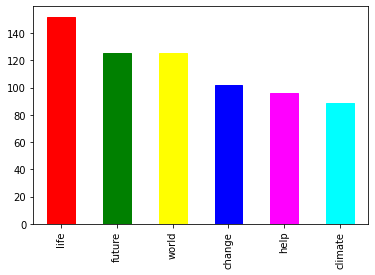

In [309]:
color=['red','green','yellow','blue','magenta','cyan']

words=getWords(ted['title'])
word_color=getWordsColor(words,color)
plotWords(words,color)

Tra le paroli più comuni, si può notare come siano presenti, quasi nella stessa quantità, le parole `climate` e `change`, a suggerire come uno dei temi più importanti degli ultimi anni, ossia il cambiamento climatico, venga trattato molto frequentemente anche nei talks presenti su Ted Talks. Andiamo a verificare quante volte compaiono nello stesso titolo.

In [310]:
countBoth=0
countClimate=0
countChange=0
for v in ted['title'].values:
  v = v.lower()
  if 'climate' in v and 'change' in v:
    countBoth+=1
  if 'climate' in v:
    countClimate+=1
  if 'change' in v:
    countChange+=1
print(f"'Climate' compare {countClimate} volte, 'Change' compare {countChange} volte e compaiono entrambe nello stesso titolo {countBoth} volte")

'Climate' compare 92 volte, 'Change' compare 136 volte e compaiono entrambe nello stesso titolo 48 volte


`Change` ovviamente compare più volte essendo anche una parola che può essere usata in diversi abiti, ma è interessante notare come più del 50% delle volte la parola `Climate` compaia insieme a `Change`.



Adesso andiamo a vedere se è presente un legame tra le parole più usate ed i titoli dei 50 talks con più views

In [311]:
bestTalksByViews = ted.sort_values(by='views', ascending=False, ignore_index=True).nlargest(50, 'views')['title']
printTitleColor(bestTalksByViews, word_color)

Do schools kill creativity? 
Your body language may shape who you are 
Inside the mind of a master procrastinator 
How great leaders inspire action 
The power of vulnerability 
How to speak so that people want to listen 
My philosophy for a happy life 
The next outbreak? We're not ready 
What makes a good life? Lessons from the longest study on happiness 
Looks aren't everything. Believe me, I'm a model. 
10 things you didn't know about orgasm 
Why people believe they can't draw 
The orchestra in my mouth 
The art of misdirection 
How to spot a liar 
The danger of a single story 
The power of introverts 
The future we're building — and boring 
How to make stress your friend 
How to stop screwing yourself over 
How I held my breath for 17 minutes 
The puzzle of motivation 
My stroke of insight 
Strange answers to the psychopath test 
Questions no one knows the answers to 
10 ways to have a better conversation 
Grit: The power of passion and perseverance 
Can you solve the prisoner hat r

Si può notare come, tranne una volta `life` e `future`, le parole che abbiamo trovato che vengono utilizzate maggiormente, non compaiono nei primi 50 titoli, quindi non sono presenti legami tra temi trattati e numero di visualizzazioni.


Andiamo a vedere le parole più usate nei primi 50 titoli per vedere se sono presenti dei temi ricorrenti.

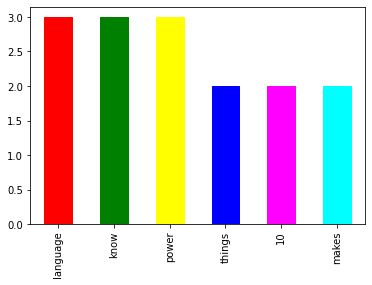

In [312]:
words=getWords(bestTalksByViews)
word_color=getWordsColor(words,color)
plotWords(words,color)

In [313]:
printTitleColor(bestTalksByViews, word_color)

Do schools kill creativity? 
Your body language may shape who you are 
Inside the mind of a master procrastinator 
How great leaders inspire action 
The power of vulnerability 
How to speak so that people want to listen 
My philosophy for a happy life 
The next outbreak? We're not ready 
What makes a good life? Lessons from the longest study on happiness 
Looks aren't everything. Believe me, I'm a model. 
10 things you didn't know about orgasm 
Why people believe they can't draw 
The orchestra in my mouth 
The art of misdirection 
How to spot a liar 
The danger of a single story 
The power of introverts 
The future we're building — and boring 
How to make stress your friend 
How to stop screwing yourself over 
How I held my breath for 17 minutes 
The puzzle of motivation 
My stroke of insight 
Strange answers to the psychopath test 
Questions no one knows the answers to 
10 ways to have a better conversation 
Grit: The power of passion and perseverance 
Can you solve the prisoner hat r

Analizzando le parole trovate, è possibile notare come nella top 50 dei talks più visti siano presenti:


*   Due talks dove viene trattato un elenco di cose da fare (ed hanno in comune la parola `10`)
*   Tre talks dove vengono analizzati i punti di forza (ed hanno in comune la parola `power`)
*   Tre talks dove viene analizzato il linguaggio (ed hanno in comune la parola `language`)
*   Due talks dove vengono dati consigli su come migliorare la propria vita e la propria persona (ed hanno in comune la parola `makes`)
